# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [ ]:
! pip install catboost

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

#from sklearn.preprocessing import StandardScaler 

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

import time
import copy
from copy import deepcopy 

#pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/autos.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Описание данных**

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

Будем решать задачу регрессии.

--------

Для дальнейшего анализа и обучения удалим столцбы, не несущие полезной информации для целей обучения моделей: дата скачивания анкеты из базы, месяц регистрации автомобиля, дата создания анкеты, количество фотографий автомобиля (в столбце только нули), почтовый индекс владельца анкеты (пользователя), дата последней активности пользователя.

In [ ]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [ ]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

------

Анализ числовых признаков:

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Почистим выбросы и некорректные данные, присутствующие в выборке. 

-------

Price — цена (евро) - удалим строки с нулевой ценой.

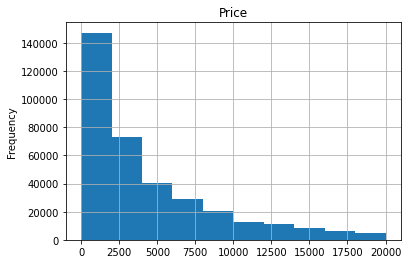

In [ ]:
df['Price'].plot(kind='hist', grid=True, title='Price')

In [ ]:
df[df['Price'] == 0]['Price'].count()

10772

In [ ]:
df = df.drop(df[df['Price'] == 0].index, axis=0)

---------

Power — мощность (л. с.) - удалим строки с нулевой мощностью.

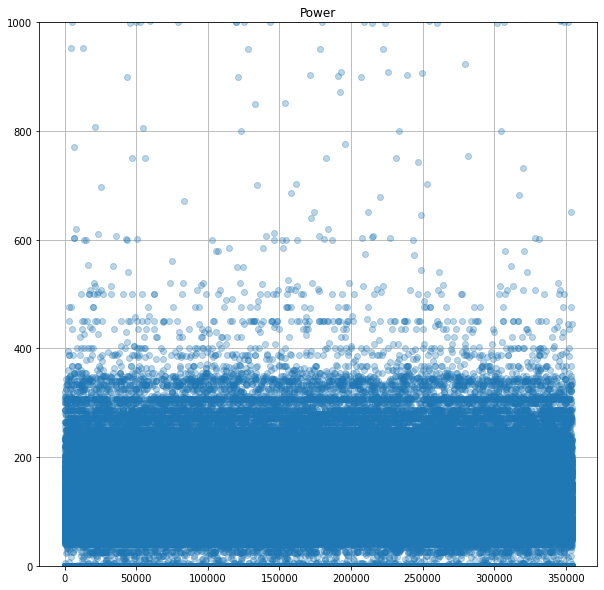

In [ ]:
df['Power'].plot(grid=True, title='Power', style='o', alpha=0.3, figsize=(10, 10), ylim=(0, 1000))

In [ ]:
df[df['Power'] == 0]['Power'].count()

36360

In [ ]:
df = df.drop(df[df['Power'] == 0].index, axis=0)

---------

RegistrationYear — год регистрации автомобиля. Будем считать корректныс период с 1900 по 2022.

In [ ]:
df[(df['RegistrationYear'] > 2022) | (df['RegistrationYear'] < 1900)]['RegistrationYear'].count()

38

In [ ]:
df = df.drop(df[(df['RegistrationYear'] > 2022) | (df['RegistrationYear'] < 1900)].index, axis=0)

----------

Обработка пропусков

In [ ]:
df.isna().mean()

Price               0.000000
VehicleType         0.069538
RegistrationYear    0.000000
Gearbox             0.019815
Power               0.000000
Model               0.040625
Kilometer           0.000000
FuelType            0.064483
Brand               0.000000
NotRepaired         0.153539
dtype: float64

In [ ]:
df.select_dtypes(include='object').columns

Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], dtype='object')

Пропуски только в категориальных признаках.

In [ ]:
col = []
for c in df.columns:
    if (df[c].isna().sum() != 0)&(df[c].dtypes == 'object'):
        df[c] = df[c].fillna('unknown')
        col.append(c)

In [ ]:
df[col].dtypes

VehicleType    object
Gearbox        object
Model          object
FuelType       object
NotRepaired    object
dtype: object

In [ ]:
df['VehicleType'].value_counts(normalize=True, dropna=False) # тип автомобильного кузова

sedan          0.270743
small          0.228464
wagon          0.193171
bus            0.085427
unknown        0.069538
convertible    0.061149
coupe          0.047637
suv            0.035713
other          0.008158
Name: VehicleType, dtype: float64

In [ ]:
df['Gearbox'].value_counts(normalize=True, dropna=False) # тип коробки передач

manual     0.783469
auto       0.196716
unknown    0.019815
Name: Gearbox, dtype: float64

In [ ]:
df['Model'].value_counts(normalize=True, dropna=False) # модель автомобиля

golf                  0.084701
other                 0.067790
3er                   0.057923
unknown               0.040625
polo                  0.036318
                        ...   
i3                    0.000016
samara                0.000016
rangerover            0.000010
serie_3               0.000010
range_rover_evoque    0.000007
Name: Model, Length: 250, dtype: float64

In [ ]:
df['FuelType'].value_counts(normalize=True, dropna=False) # тип топлива

petrol      0.625432
gasoline    0.291603
unknown     0.064483
lpg         0.015619
cng         0.001631
hybrid      0.000667
other       0.000316
electric    0.000251
Name: FuelType, dtype: float64

In [ ]:
df['NotRepaired'].value_counts(normalize=True, dropna=False) # была машина в ремонте или нет

no         0.749517
unknown    0.153539
yes        0.096944
Name: NotRepaired, dtype: float64

------

Удалим явные дубликаты. Одну и ту же анкету могли скачать (и создать) несколько раз.

In [ ]:
df.duplicated().sum()

39781

In [ ]:
df = df.drop_duplicates().reset_index(drop=True) 

---------

Поменям тип 'object' -> 'category' для обучения моделей LightGBMRegressor.

In [ ]:
# категориальные признаки
cat_features = []
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] = df[c].astype('category')
        cat_features.append(c)

In [ ]:
cat_features # категориальные признаки

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

-----

In [ ]:
data = [] # таблица с результатами
col_data = ['model', 'type', 'RMSE', 'time_search', 'time_fit', 'time_predict']

----------

## Обучение моделей

Разделим исходные данные на обучающую, валидационную и тестовую выборки. Делим в отношении 3 : 1 : 1.

In [ ]:
features = df.drop(['Price'], axis=1) # признаки
target = df['Price'] # целевой признак

In [ ]:
features.shape

(267418, 9)

In [ ]:
target.shape

(267418,)

In [ ]:
# отделим 20% данных для тестовой выборки
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345) 

In [ ]:
# отделим 25% данных для валидационной выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=12345) 

In [ ]:
features_train.shape # признаки, тренировочная выборка

(160450, 9)

In [ ]:
target_train.shape # целевой признак, тренировочная выборка

(160450,)

In [ ]:
features_valid.shape # признаки, валидационная выборка

(53484, 9)

In [ ]:
target_valid.shape # целевой признак, валидационная выборка

(53484,)

In [ ]:
features_test.shape # признаки, тестовая выборка

(53484, 9)

In [ ]:
target_test.shape # целевой признак, тестовая выборка

(53484,)

-----------

Масштабирование численных признаков пользы не принесло...

----------------

In [ ]:
def RMSE(target_valid, predictions_valid): # функция для вычисления RMSE
    return mean_squared_error(target_valid, predictions_valid) ** 0.5

------

### CatBoostRegressor

In [ ]:
start = time.time()

parameters_CBR = {'cat_features': cat_features,
                  'loss_function': 'RMSE', # значение по умолчанию
                  'iterations': 1000, # значение по умолчанию
                  'random_state': 12345,
                  'verbose': 200}

model_CBR = CatBoostRegressor(**parameters_CBR)

grid = {'learning_rate': [0.17],
        'depth': [8, 10]}

grid_search_result = model_CBR.grid_search(grid, 
                                           X=features_train, 
                                           y=target_train)

end = time.time()
time_search = end - start
print('Execution time is:', end - start)
print()

0:	learn: 5774.8658413	test: 5830.2048967	best: 5830.2048967 (0)	total: 681ms	remaining: 11m 20s
200:	learn: 1597.3406069	test: 1673.4706214	best: 1673.4706214 (200)	total: 55.5s	remaining: 3m 40s
400:	learn: 1511.1433216	test: 1641.9029511	best: 1641.9029511 (400)	total: 1m 36s	remaining: 2m 24s
600:	learn: 1461.5875478	test: 1632.1113038	best: 1632.1113038 (600)	total: 2m 19s	remaining: 1m 32s
800:	learn: 1418.4363659	test: 1624.9917208	best: 1624.9917208 (800)	total: 3m 1s	remaining: 45s
999:	learn: 1388.6783429	test: 1622.3225888	best: 1622.0969996 (973)	total: 3m 43s	remaining: 0us

bestTest = 1622.097
bestIteration = 973

0:	loss: 1622.0969996	best: 1622.0969996 (0)	total: 3m 43s	remaining: 3m 43s
0:	learn: 5774.8915356	test: 5835.2135702	best: 5835.2135702 (0)	total: 363ms	remaining: 6m 2s
200:	learn: 1499.4411767	test: 1652.4440338	best: 1652.4440338 (200)	total: 1m 5s	remaining: 4m 18s
400:	learn: 1392.4553401	test: 1630.2801463	best: 1630.1787516 (397)	total: 2m 13s	remaining

In [ ]:
start = time.time()

predictions_valid = model_CBR.predict(features_valid) # получим предсказания модели на валидационной выборке

end = time.time()
time_predict = end - start
print('Execution time is:', end - start)
print()

Execution time is: 1.3159332275390625



In [ ]:
result = RMSE(target_valid, predictions_valid) # значение метрики RMSE на валидационной выборке

print("RMSE модели CatBoostRegressor на валидационной выборке:", result)

data.append(['CatBoostRegressor', 'valid', result, time_search, '-', time_predict])

RMSE модели CatBoostRegressor на валидационной выборке: 1607.817586782856


------

### LightGBMRegressor

In [ ]:
gridParams = {
    'learning_rate': [0.15],
    'num_leaves': [50],
    'n_estimators': [200, 300],
    'objective' : ['regression'],
    'random_state' : [12345] 
    }

In [ ]:
start = time.time()

model = lgb.LGBMRegressor()
model_LGBMR = RandomizedSearchCV(model, gridParams ,verbose=1 ,cv=10 ,n_jobs = -1, n_iter=10)

end = time.time()
time_search = end - start
print('Execution time is:', end - start)
print()

Execution time is: 0.0002009868621826172



In [ ]:
start = time.time()

model_LGBMR.fit(features_train, target_train)

end = time.time()
time_fit = end - start
print('Execution time is:', end - start)
print()

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Execution time is: 49.02857565879822



In [ ]:
model_LGBMR.best_params_

{'learning_rate': 0.15,
 'n_estimators': 300,
 'num_leaves': 50,
 'objective': 'regression',
 'random_state': 12345}

In [ ]:
start = time.time()

predictions_valid = model_LGBMR.predict(features_valid) # получим предсказания модели на валидационной выборке

end = time.time()
time_predict = end - start
print('Execution time is:', end - start)
print()

Execution time is: 0.7196335792541504



In [ ]:
result = RMSE(target_valid, predictions_valid) # значение метрики RMSE на валидационной выборке

print("RMSE модели LightGBMRegressor на валидационной выборке:", result)

data.append(['LightGBMRegressor', 'valid', result, time_search, time_fit, time_predict])

RMSE модели LightGBMRegressor на валидационной выборке: 1615.2481962988584


---------

Для обработки данных моделями дерева решений, случайного леса и линейной регрессии применим прямое кодирование категориальных признаков (One-Hot Encoding, OHE). 

In [ ]:
features_train_enc = deepcopy(features_train)
features_valid_enc = deepcopy(features_valid)
features_test_enc = deepcopy(features_test)

In [ ]:
cat_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [ ]:
col = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [ ]:
features_train_enc = pd.get_dummies(features_train_enc, columns = col, drop_first=True)
features_valid_enc = pd.get_dummies(features_valid_enc, columns = col, drop_first=True)
features_test_enc = pd.get_dummies(features_test_enc, columns = col, drop_first=True)

In [ ]:
features_train_enc.shape

(160450, 310)

-----

### DecisionTreeRegressor

In [ ]:
scoring = make_scorer(RMSE, greater_is_better=False) # scoring=scoring для cross_val_score

In [ ]:
start = time.time()

best_modelDTR = None
best_depthDTR = 0
best_rmseDTR = 10000

for depth in range(1, 20): # в цикле меняем гиперпараметр - максимальную глубину дерева

    model = DecisionTreeRegressor(random_state=12345, max_depth=depth) # модель - дерево решений, с заданной глубиной дерева
    
    score = abs(sum(cross_val_score(model, features_train_enc, target_train, scoring=scoring, cv=3)) / 3)
    
    if score < best_rmseDTR:
        best_modelDTR = model
        best_depthDTR = depth
        best_rmseDTR = score

print("Модель 'Дерево решений', глубина дерева:", best_depthDTR)

end = time.time()
time_search = end - start
print('Execution time is:', end - start)
print()

Модель 'Дерево решений', глубина дерева: 14
Execution time is: 120.63101243972778



In [ ]:
start = time.time()

best_modelDTR.fit(features_train_enc, target_train)

end = time.time()
time_fit = end - start
print('Execution time is:', end - start)
print()

Execution time is: 4.991910457611084



In [ ]:
start = time.time()

predictions_valid = best_modelDTR.predict(features_valid_enc) # получим предсказания модели на валидационной выборке

end = time.time()
time_predict = end - start
print('Execution time is:', end - start)
print()

Execution time is: 0.0800325870513916



In [ ]:
result = RMSE(target_valid, predictions_valid) # значение метрики RMSE на валидационной выборке

print("RMSE модели DecisionTreeRegressor на валидационной выборке:", result)

data.append(['DecisionTreeRegressor', 'valid', result, time_search, time_fit, time_predict])

RMSE модели DecisionTreeRegressor на валидационной выборке: 1946.9698627632672


----------

### RandomForestRegressor

In [ ]:
start = time.time()

best_modelRFR = None
best_depthRFR = 0
best_est = 0
best_rmseRFR = 10000

for est in range(1, 11, 2): # в цикле меняем гиперпараметр - максимальное количество деревьев
    for depth in range(1, 21, 2): # в цикле меняем гиперпараметр - максимальную глубину дерева

        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) # случайный лес
    
        score = abs(sum(cross_val_score(model, features_train_enc, target_train, scoring=scoring, cv=3)) / 3)
    
        if score < best_rmseRFR:
            best_modelRFR = model
            best_depthRFR = depth
            best_est = est
            best_rmseRFR = score

            
print("Модель 'Случайный лес', количество деревьев:", best_est, ", глубина дерева:", best_depthRFR)

end = time.time()
time_search = end - start
print('Execution time is:', end - start)
print()

Модель 'Случайный лес', количество деревьев: 9 , глубина дерева: 19
Execution time is: 914.797607421875



In [ ]:
start = time.time()

best_modelRFR.fit(features_train_enc, target_train)

end = time.time()
time_fit = end - start
print('Execution time is:', end - start)
print()

Execution time is: 31.251786947250366



In [ ]:
start = time.time()

predictions_valid = best_modelRFR.predict(features_valid_enc) # получим предсказания модели на валидационной выборке

end = time.time()
time_predict = end - start
print('Execution time is:', end - start)
print()

Execution time is: 0.20589733123779297



In [ ]:
result = RMSE(target_valid, predictions_valid) # значение метрики RMSE на валидационной выборке

print("RMSE модели RandomForestRegressor на валидационной выборке:", result)

data.append(['RandomForestRegressor', 'valid', result, time_search, time_fit, time_predict])

RMSE модели RandomForestRegressor на валидационной выборке: 1746.8291833187725


-----------

### LinearRegression

In [ ]:
modelLinR = LinearRegression() # инициализируем модель LinearRegression

In [ ]:
start = time.time()

modelLinR.fit(features_train_enc, target_train)

end = time.time()
time_fit = end - start
print('Execution time is:', end - start)
print()

Execution time is: 4.98356556892395



In [ ]:
start = time.time()

predictions_valid = modelLinR.predict(features_valid_enc) # получим предсказания модели на валидационной выборке

end = time.time()
time_predict = end - start
print('Execution time is:', end - start)
print()

Execution time is: 0.11739587783813477



In [ ]:
result = RMSE(target_valid, predictions_valid) # значение метрики RMSE на валидационной выборке

print("RMSE модели LinearRegression на валидационной выборке:", result)

data.append(['LinearRegression', 'valid', result, '-', time_fit, time_predict])

RMSE модели LinearRegression на валидационной выборке: 2842.541853861626


## Анализ моделей

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [ ]:
df_result = pd.DataFrame(data=data , columns=col_data) # таблица с результатами

In [ ]:
df_result

,model,type,RMSE,time_search,time_fit,time_predict
0,CatBoostRegressor,valid,1607.817587,1891.652939,-,1.315933
1,LightGBMRegressor,valid,1615.248196,0.000201,49.028576,0.719634
2,DecisionTreeRegressor,valid,1946.969863,120.631012,4.99191,0.080033
3,RandomForestRegressor,valid,1746.829183,914.797607,31.251787,0.205897
4,LinearRegression,valid,2842.541854,-,4.983566,0.117396


Проведем тестирование на модели CatBoostRegressor, показавшей лучшие результаты на валидационной выборке:

In [ ]:
start = time.time()

predictions_test = model_CBR.predict(features_test) # получим предсказания модели на тестовой выборке

end = time.time()
time_predict = end - start
print('Execution time is:', end - start)
print()

Execution time is: 1.3114981651306152



In [ ]:
result = RMSE(target_test, predictions_test) # значение метрики RMSE на тестовой выборке

print("RMSE модели CatBoostRegressor на тестовой выборке:", result)

data.append(['-', '-', '-','-', '-','-'])
data.append(['CatBoostRegressor', 'test', result, '-','-', time_predict])

RMSE модели CatBoostRegressor на тестовой выборке: 1620.1674034073635


In [ ]:
df_result = pd.DataFrame(data=data , columns=col_data) # таблица с результатами

In [ ]:
df_result

,model,type,RMSE,time_search,time_fit,time_predict
0,CatBoostRegressor,valid,1607.817587,1891.652939,-,1.315933
1,LightGBMRegressor,valid,1615.248196,0.000201,49.028576,0.719634
2,DecisionTreeRegressor,valid,1946.969863,120.631012,4.99191,0.080033
3,RandomForestRegressor,valid,1746.829183,914.797607,31.251787,0.205897
4,LinearRegression,valid,2842.541854,-,4.983566,0.117396
5,-,-,-,-,-,-
6,CatBoostRegressor,test,1620.167403,-,-,1.311498


Важность признаков:

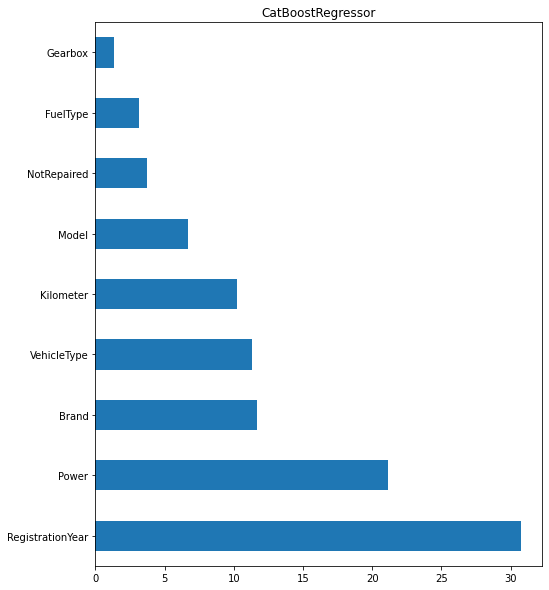

In [ ]:
feat_imp = pd.Series(model_CBR.feature_importances_, index=features_train.columns)
feat_imp.nlargest(30).plot(
    kind='barh', title='CatBoostRegressor', figsize=(8,10))

**Выводы:**

* Подбор гиперпараметров модели CatBoostRegressor, а также модели Случайный лес выполняется очень долго.

* Модель CatBoostRegressor быстрее и точнее предсказывает, чем модель LightGBMRegressor.

* Модели Решающее дерево и Линейная регрессия обучаются и предсказывают быстро, но качество предсказаний хуже, чем у бустинговых моделей и модели Случайного леса.

* Лучшее качество показала модель CatBoostRegressor: 

RMSE модели CatBoostRegressor на валидационной выборке: 1607.817586782856

* Наиболее важные признаки для CatBoostRegressor Год регистрации автомобиля и Мощность.